BERT, Classfication layer

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


train_data = pd.read_csv('../datasets/data_train.csv')
test_data = pd.read_csv('../datasets/data_test.csv')
valid_data = pd.read_csv('../datasets/data_valid.csv')

In [2]:
def extract_texts_labels(data, label_encoder):
    texts = data['data'].values
    labels = data['label'].values
    encoded_labels = label_encoder.fit_transform(labels)
    return texts, encoded_labels

In [3]:
label_encoder = LabelEncoder()
train_texts, train_labels = extract_texts_labels(train_data, label_encoder)
test_texts, test_labels = extract_texts_labels(test_data, label_encoder)
valid_texts, valid_labels = extract_texts_labels(valid_data, label_encoder)


In [4]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-german-cased')

# Tokenize the data
train_encodings = tokenizer(train_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
test_encodings = tokenizer(test_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
valid_encodings = tokenizer(valid_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)

In [5]:
import tensorflow as tf

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

train_dataset = create_dataset(train_encodings, train_labels)
test_dataset = create_dataset(test_encodings, test_labels)
valid_dataset = create_dataset(valid_encodings, valid_labels)

2024-07-27 12:21:26.203018: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-27 12:21:26.203042: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-27 12:21:26.203045: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-27 12:21:26.203058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-27 12:21:26.203068: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
from transformers import TFBertForSequenceClassification

# Load the BERT model for sequence classification with the number of output labels
model = TFBertForSequenceClassification.from_pretrained('google-bert/bert-base-german-cased', num_labels=len(label_encoder.classes_))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
metric=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.F1Score(average="macro", name='f1_score'),
    ]

In [10]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=metric
)


In [11]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_f1_score',  
        patience=3,         
        restore_best_weights=True,
        verbose=1
    )

model.fit(train_dataset,
        validation_data=valid_dataset,
        epochs = 15,
        batch_size = 32,
        callbacks=[early_stopping_callback]
        )



Epoch 1/15


ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1672, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/sg/lvbmg7vj0wsc8c5sn3vhh4rc0000gn/T/__autograph_generated_file6bq1l3he.py", line 37, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "/var/folders/sg/lvbmg7vj0wsc8c5sn3vhh4rc0000gn/T/__autograph_generated_fileh2dwnlat.py", line 17, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).bert, (), dict(input_ids=ag__.ld(input_ids), attention_mask=ag__.ld(attention_mask), token_type_ids=ag__.ld(token_type_ids), position_ids=ag__.ld(position_ids), head_mask=ag__.ld(head_mask), inputs_embeds=ag__.ld(inputs_embeds), output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
    File "/var/folders/sg/lvbmg7vj0wsc8c5sn3vhh4rc0000gn/T/__autograph_generated_file6bq1l3he.py", line 37, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "/var/folders/sg/lvbmg7vj0wsc8c5sn3vhh4rc0000gn/T/__autograph_generated_file2n1ycrnr.py", line 76, in tf__call
        (batch_size, seq_length) = ag__.ld(input_shape)

    ValueError: Exception encountered when calling layer 'tf_bert_for_sequence_classification' (type TFBertForSequenceClassification).
    
    in user code:
    
        File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1734, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 1746, in call  *
            outputs = self.bert(
        File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/var/folders/sg/lvbmg7vj0wsc8c5sn3vhh4rc0000gn/T/__autograph_generated_file6bq1l3he.py", line 37, in tf__run_call_with_unpacked_inputs
            retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
        File "/var/folders/sg/lvbmg7vj0wsc8c5sn3vhh4rc0000gn/T/__autograph_generated_file2n1ycrnr.py", line 76, in tf__call
            (batch_size, seq_length) = ag__.ld(input_shape)
    
        ValueError: Exception encountered when calling layer 'bert' (type TFBertMainLayer).
        
        in user code:
        
            File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1734, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 873, in call  *
                batch_size, seq_length = input_shape
        
            ValueError: not enough values to unpack (expected 2, got 1)
        
        
        Call arguments received by layer 'bert' (type TFBertMainLayer):
          • input_ids=tf.Tensor(shape=(400,), dtype=int32)
          • attention_mask=tf.Tensor(shape=(400,), dtype=int32)
          • token_type_ids=tf.Tensor(shape=(400,), dtype=int32)
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • encoder_hidden_states=None
          • encoder_attention_mask=None
          • past_key_values=None
          • use_cache=None
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=True
    
    
    Call arguments received by layer 'tf_bert_for_sequence_classification' (type TFBertForSequenceClassification):
      • input_ids={'input_ids': 'tf.Tensor(shape=(400,), dtype=int32)', 'token_type_ids': 'tf.Tensor(shape=(400,), dtype=int32)', 'attention_mask': 'tf.Tensor(shape=(400,), dtype=int32)'}
      • attention_mask=None
      • token_type_ids=None
      • position_ids=None
      • head_mask=None
      • inputs_embeds=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • labels=None
      • training=True


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset.batch(32))
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

246/246 [==============================] - 183s 740ms/step - loss: 0.9367 - accuracy: 0.6126
Loss: 0.9366819262504578
Accuracy: 0.6125988364219666


In [ ]:
model.save_pretrained('bert_classify')
tokenizer.save_pretrained('bert_classify_tokenizer')

('bert_classify_tokenizer/tokenizer_config.json',
 'bert_classify_tokenizer/special_tokens_map.json',
 'bert_classify_tokenizer/vocab.txt',
 'bert_classify_tokenizer/added_tokens.json')

In [ ]:
import numpy as np
predictions = model.predict(test_dataset.batch(32))
predicted_labels = np.argmax(predictions.logits, axis=-1)

# Decode class labels to original labels
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# True labels from the test set
true_labels = label_encoder.inverse_transform(test_labels)

# Create a DataFrame to compare
comparison_df = pd.DataFrame({'Text': test_texts, 'True Label': true_labels, 'Predicted Label': decoded_predictions})

246/246 [==============================] - 148s 583ms/step


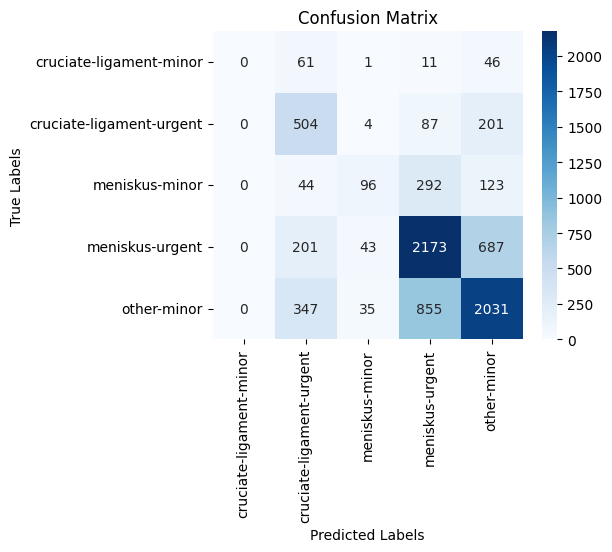

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, decoded_predictions, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

 cruciate-ligament-minor       0.00      0.00      0.00       119
cruciate-ligament-urgent       0.44      0.63      0.52       796
          meniskus-minor       0.54      0.17      0.26       555
         meniskus-urgent       0.64      0.70      0.67      3104
             other-minor       0.66      0.62      0.64      3268

                accuracy                           0.61      7842
               macro avg       0.45      0.43      0.42      7842
            weighted avg       0.61      0.61      0.60      7842



In [ ]:
import sys
from pathlib import Path

# Set the working directory to the project root (Thesis)
project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root))
from common.utils import eval
eval(model, test_dataset, test_labels, label_encoder, "bert_classify_hyperparam_optimize")

OperatorNotAllowedInGraphError: in user code:

    File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 2436, in predict_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 2421, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 2409, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 2377, in predict_step
        return self(x, training=False)
    File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    OperatorNotAllowedInGraphError: Exception encountered when calling layer 'tf_bert_for_sequence_classification' (type TFBertForSequenceClassification).
    
    in user code:
    
        File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1734, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 1746, in call  *
            outputs = self.bert(
        File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        OperatorNotAllowedInGraphError: Exception encountered when calling layer 'bert' (type TFBertMainLayer).
        
        in user code:
        
            File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1734, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 873, in call  *
                batch_size, seq_length = input_shape
        
            OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.
        
        
        Call arguments received by layer 'bert' (type TFBertMainLayer):
          • input_ids=tf.Tensor(shape=<unknown>, dtype=int32)
          • attention_mask=tf.Tensor(shape=<unknown>, dtype=int32)
          • token_type_ids=tf.Tensor(shape=<unknown>, dtype=int32)
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • encoder_hidden_states=None
          • encoder_attention_mask=None
          • past_key_values=None
          • use_cache=None
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=False
    
    
    Call arguments received by layer 'tf_bert_for_sequence_classification' (type TFBertForSequenceClassification):
      • input_ids={'input_ids': 'tf.Tensor(shape=<unknown>, dtype=int32)', 'token_type_ids': 'tf.Tensor(shape=<unknown>, dtype=int32)', 'attention_mask': 'tf.Tensor(shape=<unknown>, dtype=int32)'}
      • attention_mask=None
      • token_type_ids=None
      • position_ids=None
      • head_mask=None
      • inputs_embeds=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • labels=None
      • training=False
